In [10]:
%matplotlib inline
# import modules
import pandas as pd
import scipy.stats as st
import numpy as np
import xgboost as xgb
import operator
from matplotlib import pylab as plt

from sklearn.model_selection import train_test_split  
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# load data files
contacts_pre_2017=pd.read_csv('../data/Train/Contacts_Pre_2017.csv')
resolution_pre_2017=pd.read_csv('../data/Train/Resolution_Pre_2017.csv', encoding='iso8859-1')

contacts2017=pd.read_csv('../data/Test/Contacts2017.csv')
resolution2017=pd.read_csv('../data/Test/Resolution2017.csv')

In [3]:
# separate predictor and target variables
contact_ID = contacts2017['ID']
X_c = contacts_pre_2017.loc[:, ['CONTACT.TYPE']]
y_c = contacts_pre_2017['Contacts']
test_c = contacts2017.loc[:, ['CONTACT.TYPE']]

res_ID = resolution2017['ID']
X_r = resolution_pre_2017.loc[:, ['Category', 'Subject']]
y_r = resolution_pre_2017['Resolution'] # Target variable
test_r = resolution2017.loc[:, ['Category', 'Subject']]

In [4]:
# define label encoder
lb_temp = LabelEncoder()
# replace the Contact Type column
X_c['CONTACT.TYPE'] = lb_temp.fit_transform(X_c['CONTACT.TYPE'])
test_c['CONTACT.TYPE'] = lb_temp.fit_transform(test_c['CONTACT.TYPE'])
# replace Category & Subject columns
X_r['Category'] = lb_temp.fit_transform(X_r['Category'])
X_r['Subject'] = lb_temp.fit_transform(X_r['Subject'])
test_r['Category'] = lb_temp.fit_transform(test_r['Category'])
test_r['Subject'] = lb_temp.fit_transform(test_r['Subject'])

In [5]:
x_train,x_val,y_train,y_val=train_test_split(X_c,y_c,test_size=0.3,random_state=42)

In [7]:
dtrain = xgb.DMatrix(np.array(x_train), label=y_train)
dval=xgb.DMatrix(np.array(x_val),label=y_val)
dtest = xgb.DMatrix(np.array(test_c))

In [8]:
# classification
xgb_params = {
    'seed': 7,
    # 'colsample_bytree': 0.7,
    'silent': 0,
    'subsample': 0.8,
    'learning_rate': 0.3, #0.2
    'objective': 'reg:linear',
    'max_depth': 5, #3
    # 'num_parallel_tree': 1,
    #'min_child_weight': 500,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
}
num_round=300
watchlist=[(dtrain,'train'),(dval,'eval')]

gbdt = xgb.train(xgb_params, dtrain,num_round,watchlist,early_stopping_rounds=50)

[0]	train-rmse:959.334	eval-rmse:947.58
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:854.105	eval-rmse:844.622
[2]	train-rmse:800.018	eval-rmse:792.181
[3]	train-rmse:770.148	eval-rmse:763.575
[4]	train-rmse:755.613	eval-rmse:749.893
[5]	train-rmse:748.374	eval-rmse:743.237
[6]	train-rmse:744.382	eval-rmse:739.688
[7]	train-rmse:742.447	eval-rmse:738.056
[8]	train-rmse:741.622	eval-rmse:737.41
[9]	train-rmse:741.237	eval-rmse:737.137
[10]	train-rmse:740.966	eval-rmse:736.968
[11]	train-rmse:740.875	eval-rmse:736.92
[12]	train-rmse:740.775	eval-rmse:736.882
[13]	train-rmse:740.744	eval-rmse:736.876
[14]	train-rmse:740.703	eval-rmse:736.875
[15]	train-rmse:740.661	eval-rmse:736.916
[16]	train-rmse:740.668	eval-rmse:736.898
[17]	train-rmse:740.677	eval-rmse:736.887
[18]	train-rmse:740.679	eval-rmse:736.885
[19]	train-rmse:740.664	eval-rmse:736.906
[20]	train-rmse:740.66	eval-rm

Index(['CONTACT.TYPE'], dtype='object')
[('CONTACT.TYPE', 486)]


/Users/shiv/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


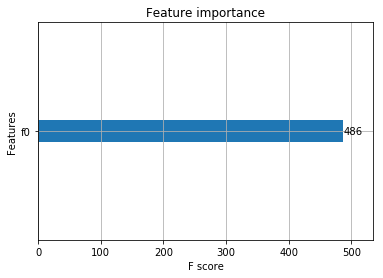

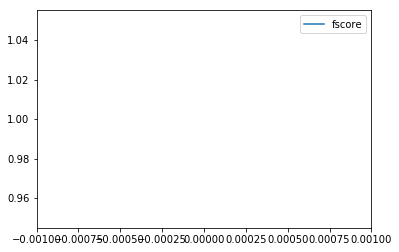

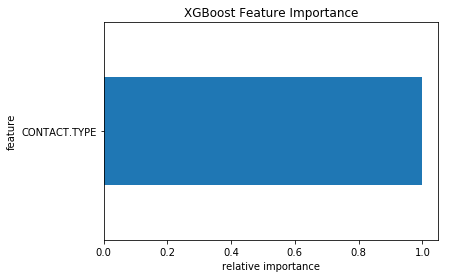

In [11]:
#feature importance
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()
ceate_feature_map(list(X_c.columns))
print(X_c.columns)
xgb.plot_importance(gbdt)
importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
print(importance)
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False)
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('contacts_feature_importance_xgb.png')

In [12]:
#output file
submission=pd.DataFrame({'ID':contact_ID,'Contacts':gbdt.predict(dtest)})
submission.to_csv('Contacts.csv',index=False)

In [13]:
x_train,x_val,y_train,y_val=train_test_split(X_r,y_r,test_size=0.3,random_state=42)

In [14]:
dtrain = xgb.DMatrix(np.array(x_train), label=y_train)
dval=xgb.DMatrix(np.array(x_val),label=y_val)
dtest = xgb.DMatrix(np.array(test_r))

In [15]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthread=-1)  

In [16]:
gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(x_train, y_train)  
gs.best_score_, gs.best_params_

KeyboardInterrupt: 

In [17]:
# classification
xgb_params = {
    'seed': 7,
    'colsample_bytree': 0.96900124211361693,
    'gamma': 7.2243949984428726,
    'silent': 0,
    'n_estimators': 34,
    'reg_alpha': 115.10050000738525,
    'subsample': 0.94666061968846671,
    'learning_rate': 0.25488466025201351,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 1.5874540252413947,
    'eval_metric': 'rmse'
}
num_round=300 #800
watchlist=[(dtrain,'train'),(dval,'eval')]

gbdt = xgb.train(xgb_params, dtrain,num_round,watchlist,early_stopping_rounds=50)

[0]	train-rmse:16.7751	eval-rmse:16.4913
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:16.7039	eval-rmse:16.4193
[2]	train-rmse:16.6453	eval-rmse:16.3593
[3]	train-rmse:16.613	eval-rmse:16.3262
[4]	train-rmse:16.5949	eval-rmse:16.3077
[5]	train-rmse:16.5879	eval-rmse:16.3007
[6]	train-rmse:16.5808	eval-rmse:16.2933
[7]	train-rmse:16.5786	eval-rmse:16.2912
[8]	train-rmse:16.5773	eval-rmse:16.29
[9]	train-rmse:16.5745	eval-rmse:16.287
[10]	train-rmse:16.5728	eval-rmse:16.2852
[11]	train-rmse:16.5726	eval-rmse:16.285
[12]	train-rmse:16.5717	eval-rmse:16.284
[13]	train-rmse:16.5712	eval-rmse:16.2834
[14]	train-rmse:16.5711	eval-rmse:16.2833
[15]	train-rmse:16.5711	eval-rmse:16.2833
[16]	train-rmse:16.5711	eval-rmse:16.2833
[17]	train-rmse:16.5711	eval-rmse:16.2833
[18]	train-rmse:16.5711	eval-rmse:16.2833
[19]	train-rmse:16.5708	eval-rmse:16.283
[20]	train-rmse:16.5706	eval-rmse:

Index(['Category', 'Subject'], dtype='object')
[('Category', 96), ('Subject', 502)]


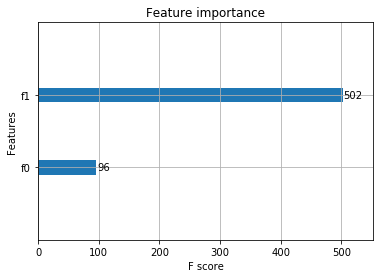

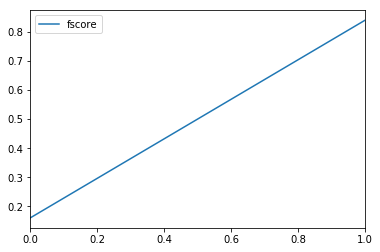

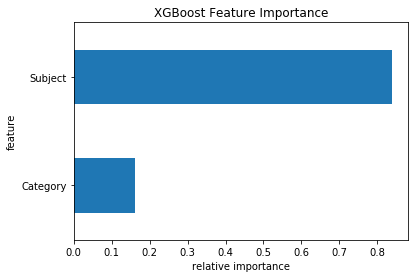

In [18]:
#feature importance
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()
ceate_feature_map(list(X_r.columns))
print(X_r.columns)
xgb.plot_importance(gbdt)
importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
print(importance)
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False)
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('res_feature_importance_xgb.png')

In [19]:
#output file
submission_=pd.DataFrame({'ID':res_ID,'Resolution':gbdt.predict(dtest)})
submission_.to_csv('Resolution.csv',index=False)